In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# print gpu info
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA A10


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasetsforecast.long_horizon import LongHorizon

from neuralforecast.core import NeuralForecast
from neuralforecast.models import iTransformer, TimeXer, VanillaTransformer

/home/ethan/.conda/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-06 15:36:57,883	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-06 15:36:57,965	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
def load_data(name):
    if name == "ettm1":
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTm1')
        Y_df = Y_df[Y_df['unique_id'] == 'OT']
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 11520
        test_size = 11520
        freq = '15T'
    elif name == "ettm2":
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTm2')
        Y_df = Y_df[Y_df['unique_id'] == 'OT']
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 11520
        test_size = 11520
        freq = '15T'
    elif name == 'etth1':
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 2880
        test_size = 2880
        freq = 'H'
    elif name == "etth2":
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTh2')
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 2880
        test_size = 2880
        freq = 'H'

    return Y_df, val_size, test_size, freq

## Test accuracy of flash attention

In [5]:
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

Y_df, val_size, test_size, freq = load_data('ettm1')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='iTransformer_flash'),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='TimeXer_flash'),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='VanillaTransformer_flash'),
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

ettm1_evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=[
    'iTransformer', 'TimeXer', 'VanillaTransformer', 'iTransformer_flash', 'TimeXer_flash', 'VanillaTransformer_flash'])
ettm1_evaluation.to_csv('ettm1_results.csv', index=False, header=True)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 

Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.213, valid_loss=0.183] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.213, valid_loss=0.183]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa


Epoch 899: 100%|██████████| 1/1 [00:01<00:00,  0.84it/s, v_num=2, train_loss_step=0.249, train_loss_epoch=0.249, valid_loss=0.173]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 899: 100%|██████████| 1/1 [00:02<00:00,  0.42it/s, v_num=4, train_loss_step=0.211, train_loss_epoch=0.211, valid_loss=0.171]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 147 K  | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 49.2 K | train
-----------------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Tota


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=6, train_loss_step=0.194, train_loss_epoch=0.194, valid_loss=0.174] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=6, train_loss_step=0.194, train_loss_epoch=0.194, valid_loss=0.174]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, v_num=8, train_loss_step=0.218, train_loss_epoch=0.218, valid_loss=0.171]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, v_num=8, train_loss_step=0.218, train_loss_epoch=0.218, valid_loss=0.171]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 899: 100%|██████████| 1/1 [00:01<00:00,  0.67it/s, v_num=10, train_loss_step=0.211, train_loss_epoch=0.211, valid_loss=0.172]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.86it/s]


In [6]:
Y_df, val_size, test_size, freq = load_data('ettm2')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='iTransformer_flash'),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='TimeXer_flash'),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='VanillaTransformer_flash'),
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

ettm2_evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=[
    'iTransformer', 'TimeXer', 'VanillaTransformer', 'iTransformer_flash', 'TimeXer_flash', 'VanillaTransformer_flash'])
ettm2_evaluation.to_csv('ettm2_results.csv', index=False, header=True)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embe

Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, v_num=12, train_loss_step=0.207, train_loss_epoch=0.207, valid_loss=0.221] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, v_num=12, train_loss_step=0.207, train_loss_epoch=0.207, valid_loss=0.221]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.88it/s, v_num=14, train_loss_step=0.203, train_loss_epoch=0.203, valid_loss=0.218]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.87it/s, v_num=14, train_loss_step=0.203, train_loss_epoch=0.203, valid_loss=0.218]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 899: 100%|██████████| 1/1 [00:02<00:00,  0.41it/s, v_num=16, train_loss_step=0.211, train_loss_epoch=0.211, valid_loss=0.236]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 147 K  | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 49.2 K | train
-----------------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Tota


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, v_num=18, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.230] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, v_num=18, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.230]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.93it/s, v_num=20, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.217]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.93it/s, v_num=20, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.217]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train_loss_step=0.199, train_loss_epoch=0.199, valid_loss=0.233]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train_loss_step=0.199, train_loss_epoch=0.199, valid_loss=0.233]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.86it/s]


In [7]:
Y_df, val_size, test_size, freq = load_data('etth1')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='iTransformer_flash'),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='TimeXer_flash'),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='VanillaTransformer_flash'),
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

etth1_evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=[
    'iTransformer', 'TimeXer', 'VanillaTransformer', 'iTransformer_flash', 'TimeXer_flash', 'VanillaTransformer_flash'])
etth1_evaluation.to_csv('etth1_results.csv', index=False, header=True)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embe

Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=24, train_loss_step=0.286, train_loss_epoch=0.286, valid_loss=0.248] 


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, v_num=26, train_loss_step=0.288, train_loss_epoch=0.288, valid_loss=0.252]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, v_num=28, train_loss_step=0.267, train_loss_epoch=0.267, valid_loss=0.311]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 147 K  | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 49.2 K | train
-----------------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Tota


Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s, v_num=30, train_loss_step=0.300, train_loss_epoch=0.300, valid_loss=0.251] 


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, v_num=32, train_loss_step=0.293, train_loss_epoch=0.293, valid_loss=0.263]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, v_num=34, train_loss_step=0.265, train_loss_epoch=0.265, valid_loss=0.315]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


In [8]:
Y_df, val_size, test_size, freq = load_data('etth2')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='iTransformer_flash'),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='TimeXer_flash'),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3, atten='flash', alias='VanillaTransformer_flash'),
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

etth2_evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=[
    'iTransformer', 'TimeXer', 'VanillaTransformer', 'iTransformer_flash', 'TimeXer_flash', 'VanillaTransformer_flash'])
etth2_evaluation.to_csv('etth2_results.csv', index=False, header=True)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embe

Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s, v_num=36, train_loss_step=0.298, train_loss_epoch=0.298, valid_loss=0.342] 


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa


Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s, v_num=38, train_loss_step=0.298, train_loss_epoch=0.298, valid_loss=0.345]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s, v_num=40, train_loss_step=0.325, train_loss_epoch=0.325, valid_loss=0.433]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 147 K  | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 49.2 K | train
-----------------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Tota


Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s, v_num=42, train_loss_step=0.311, train_loss_epoch=0.311, valid_loss=0.336] 


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa


Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s, v_num=44, train_loss_step=0.304, train_loss_epoch=0.304, valid_loss=0.338]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, v_num=46, train_loss_step=0.328, train_loss_epoch=0.328, valid_loss=0.428]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


In [9]:
files = ['etth1_results.csv', 'etth2_results.csv', 'ettm1_results.csv', 'ettm2_results.csv']
datasets = ['etth1', 'etth2', 'ettm1', 'ettm2']

dataframes = []

for file, dataset in zip(files, datasets):
    df = pd.read_csv(file)
    df['dataset'] = dataset

    dataframes.append(df)

full_df = pd.concat(dataframes, ignore_index=True)
full_df = full_df.drop(['unique_id'], axis=1)
full_df

,metric,iTransformer,TimeXer,VanillaTransformer,iTransformer_flash,TimeXer_flash,VanillaTransformer_flash,dataset
0,mae,0.182074,0.190738,0.423302,0.190037,0.194406,0.435296,etth1
1,mse,0.056537,0.062604,0.256112,0.061338,0.061036,0.264120,etth1
2,mae,0.299830,0.282590,0.345463,0.296674,0.289599,0.343691,etth2
3,mse,0.147141,0.130797,0.188034,0.144497,0.137717,0.186388,etth2
4,mae,0.134395,0.129476,0.208027,0.128842,0.124142,0.207396,ettm1
5,mse,0.031579,0.028690,0.068338,0.028937,0.026742,0.067712,ettm1
6,mae,0.202216,0.190859,0.204771,0.200626,0.192000,0.206868,ettm2
7,mse,0.073817,0.066177,0.077508,0.071259,0.067563,0.079637,ettm2


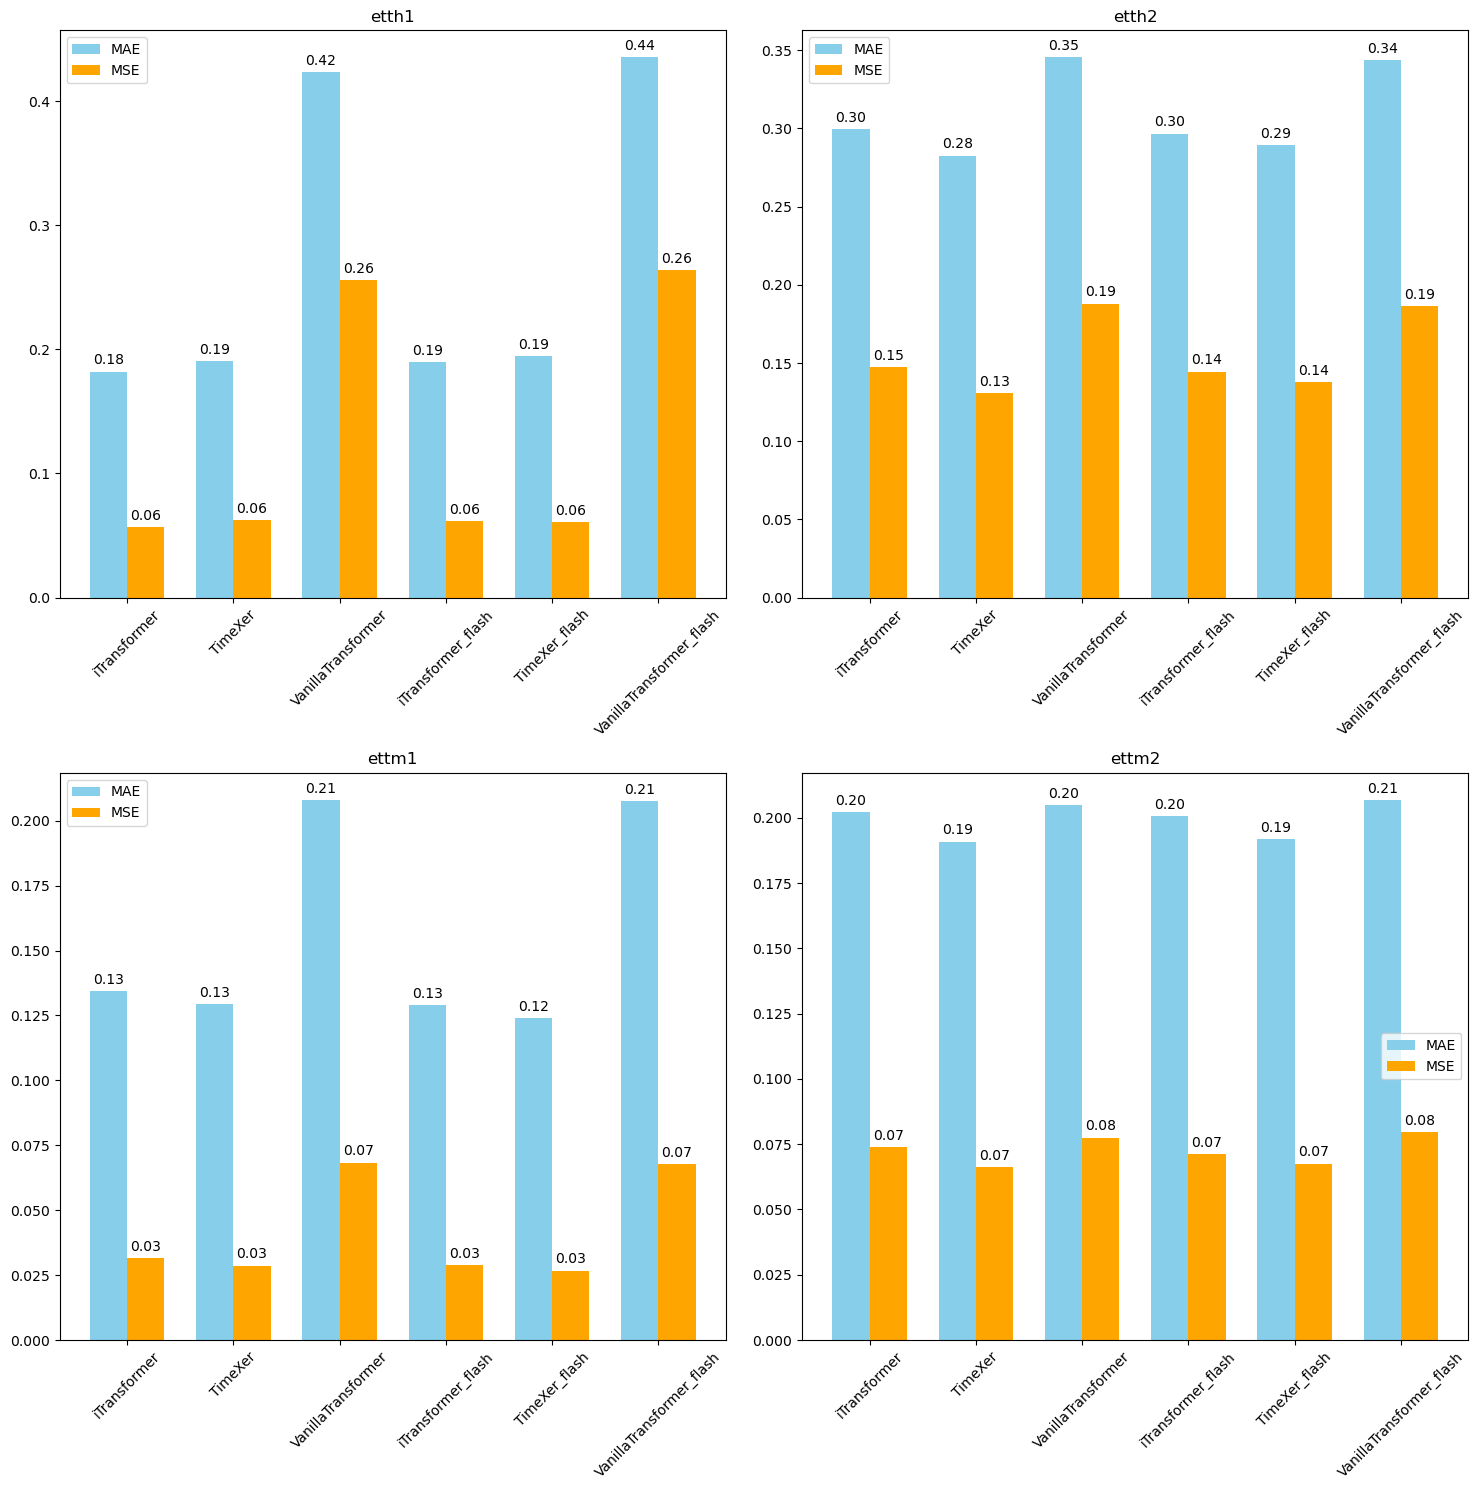

In [10]:
import matplotlib.pyplot as plt
import numpy as np

dataset_names = full_df['dataset'].unique()
model_names = ['iTransformer', 'TimeXer', 'VanillaTransformer', 'iTransformer_flash', 'TimeXer_flash', 'VanillaTransformer_flash']

fig, axs = plt.subplots(2, 2, figsize=(15, 15)) 
bar_width = 0.35  

axs = axs.flatten()

for i, dataset_name in enumerate(dataset_names):
    df_subset = full_df[(full_df['dataset'] == dataset_name) & (full_df['metric'] == 'mae')]
    mae_vals = df_subset[model_names].values.flatten()
    df_subset = full_df[(full_df['dataset'] == dataset_name) & (full_df['metric'] == 'mse')]
    mse_vals = df_subset[model_names].values.flatten()
    
    indices = np.arange(len(model_names))
    
    bars_mae = axs[i].bar(indices - bar_width / 2, mae_vals, bar_width, color='skyblue', label='MAE')
    bars_mse = axs[i].bar(indices + bar_width / 2, mse_vals, bar_width, color='orange', label='MSE')
    
    for bars in [bars_mae, bars_mse]:
        for bar in bars:
            height = bar.get_height()
            axs[i].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')
    
    axs[i].set_xticks(indices)
    axs[i].set_xticklabels(model_names, rotation=45)
    axs[i].set_title(dataset_name)
    axs[i].legend(loc='best')

plt.tight_layout()

plt.savefig('model_performance_plots.png')


## Test speed of flash attention

In [5]:
import time
import gc

# load data
Y_df, val_size, test_size, freq = load_data('ettm1')

# model definition
horizon = 96
# VanillaTransformer is too slow to train, so we use a smaller max_steps
models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, alias='iTransformer'),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, alias='TimeXer'),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=100, alias='VanillaTransformer'),
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, atten='flash', alias='iTransformer_flash'),
    TimeXer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, atten='flash', alias='TimeXer_flash'),
    VanillaTransformer(h=horizon, input_size=3*horizon, max_steps=100, atten='flash', alias='VanillaTransformer_flash'),
]


# record training times for each model
training_times = {}
for model in models:
    # clear GPU cache
    torch.cuda.empty_cache()
    
    # init NeuralForecast
    nf = NeuralForecast(models=[model], freq=freq)
    
    start_time = time.time()
    nf_preds = nf.fit(df=Y_df)
    end_time = time.time()
    training_times[model.alias] = end_time - start_time
    
    del nf
    gc.collect()

# save training times results
training_times_df = pd.DataFrame(list(training_times.items()), columns=['Model', 'Training Time (seconds)'])
training_times_df.to_csv('training_times.csv', index=False, header=True)

# print training times results
training_times_df

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 49.71it/s, v_num=78, train_loss_step=0.191, train_loss_epoch=0.191] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 46.76it/s, v_num=78, train_loss_step=0.191, train_loss_epoch=0.191]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s, v_num=79, train_loss_step=0.207, train_loss_epoch=0.207]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s, v_num=79, train_loss_step=0.207, train_loss_epoch=0.207]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=80, train_loss_step=0.285, train_loss_epoch=0.285]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=80, train_loss_step=0.285, train_loss_epoch=0.285]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 147 K  | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 49.2 K | train
-----------------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Tota

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s, v_num=81, train_loss_step=0.202, train_loss_epoch=0.202] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s, v_num=81, train_loss_step=0.202, train_loss_epoch=0.202]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | loss         | MAE                    | 0      | train
1 | padder_train | ConstantPad1d          | 0      | train
2 | scaler       | TemporalNorm           | 0      | train
3 | en_embedding | EnEmbedding            | 8.7 K  | train
4 | ex_embedding | DataEmbedding_inverted | 147 K  | train
5 | encoder      | Encoder                | 8.4 M  | train
6 | head         | FlattenHead            | 933 K  | train
----------------------------------------------------------------
9.5 M     Trainable pa

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 39.43it/s, v_num=82, train_loss_step=0.202, train_loss_epoch=0.202]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 37.13it/s, v_num=82, train_loss_step=0.202, train_loss_epoch=0.202]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 150 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.170     Total estim

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, v_num=83, train_loss_step=0.281, train_loss_epoch=0.281]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, v_num=83, train_loss_step=0.281, train_loss_epoch=0.281]


,Model,Training Time (seconds)
0,iTransformer,14.466302
1,TimeXer,17.951834
2,VanillaTransformer,52.306644
3,iTransformer_flash,12.814280
4,TimeXer_flash,15.620496
5,VanillaTransformer_flash,33.779530
